In [2]:
%%capture
!pip install roboflow
!pip install ultralytics
!pip install onnx

In [4]:
from roboflow import Roboflow
rf = Roboflow(api_key="WlsxUdgFU6oiwdDIl59k")
project = rf.workspace("vehicle-mscoco").project("vehicles-coco")
version = project.version(2)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.92, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to Vehicles-coco-2 in yolov8:: 100%|██████████| 38008/38008 [00:04<00:00, 7739.52it/s] 


In [5]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
import cv2

In [6]:
def count_images(directory):
    count = len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])
    return count

train_count = count_images('Vehicles-coco-2/train/images')
test_count = count_images('Vehicles-coco-2/test/images')
val_count = count_images('Vehicles-coco-2/valid/images')

print(f"Number of train images: {train_count}")
print(f"Number of test images: {test_count}")
print(f"Number of val images: {val_count}")


Number of train images: 13300
Number of test images: 1900
Number of val images: 3798


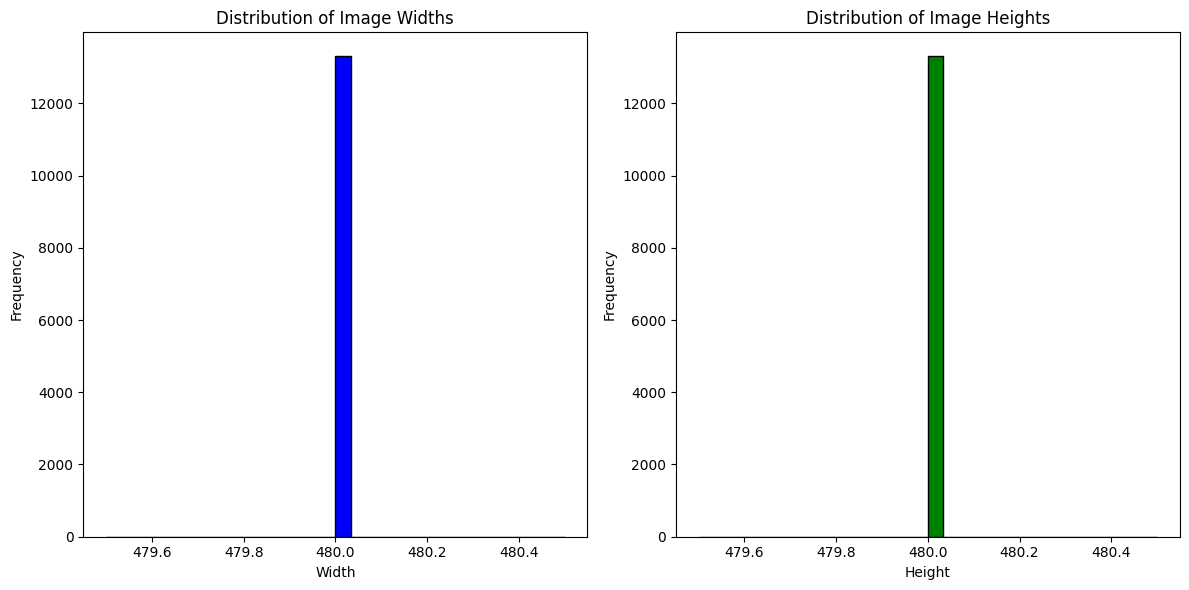

Width - Min: 480, Max: 480, Mean: 480.0, Median: 480.0
Height - Min: 480, Max: 480, Mean: 480.0, Median: 480.0


In [7]:
def get_image_sizes(directory):
    widths = []
    heights = []
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            try:
                with Image.open(os.path.join(directory, filename)) as img:
                    width, height = img.size
                    widths.append(width)
                    heights.append(height)
            except Exception as e:
                print(f"Error processing {filename}: {e}")
    return widths, heights


widths, heights = get_image_sizes('Vehicles-coco-2/train/images')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(widths, bins=30, color='blue', edgecolor='black')
plt.title('Distribution of Image Widths')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(heights, bins=30, color='green', edgecolor='black')
plt.title('Distribution of Image Heights')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"Width - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths)}, Median: {np.median(widths)}")
print(f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights)}, Median: {np.median(heights)}")


In [8]:
class_indices = {'bus': 0, 'car': 1, 'truck': 3}

def count_annotations(directory):
    counts = {name: 0 for name in class_indices.keys()}
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            with open(os.path.join(directory, filename), 'r') as file:
                for line in file:
                    class_index = int(line.split()[0])
                    if class_index in class_indices.values():
                        for name, index in class_indices.items():
                            if class_index == index:
                                counts[name] += 1
    return counts

train_counts = count_annotations('Vehicles-coco-2/train/labels')

print(f"Train annotations count: {train_counts}")

total_train_annotations = sum(train_counts.values())

percentages = {name: (count / total_train_annotations) * 100 for name, count in train_counts.items()}

print("Training data class distribution:")
for name, percentage in percentages.items():
    print(f"{name}: {percentage:.2f}%")


Train annotations count: {'bus': 4466, 'car': 32170, 'truck': 7257}
Training data class distribution:
bus: 10.17%
car: 73.29%
truck: 16.53%


# data augementation

In [9]:
def yolo_to_voc(bboxes, img_width, img_height):
    voc_bboxes = []
    for bbox in bboxes:
        x_center, y_center, width, height = bbox
        x_min = (x_center - width / 2) * img_width
        y_min = (y_center - height / 2) * img_height
        x_max = (x_center + width / 2) * img_width
        y_max = (y_center + height / 2) * img_height
        voc_bboxes.append([x_min, y_min, x_max, y_max])
    return voc_bboxes

def voc_to_yolo(bboxes, img_width, img_height):
    yolo_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        x_center = (x_min + x_max) / 2 / img_width  
        y_center = (y_min + y_max) / 2 / img_height  
        width = (x_max - x_min) / img_width         
        height = (y_max - y_min) / img_height    
        yolo_bboxes.append([x_center, y_center, width, height])
    return yolo_bboxes

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=40, p=0.9),
    A.RandomScale(scale_limit=0.2, p=0.5), 
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5) 
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))

images_dir = "/kaggle/working/Vehicles-coco-2/train/images"
labels_dir = "/kaggle/working/Vehicles-coco-2/train/labels"
output_images_dir = "/kaggle/working/Vehicles-coco-2/train/images"
output_labels_dir =  "/kaggle/working/Vehicles-coco-2/train/labels"

os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_labels_dir, exist_ok=True)

for image_filename in os.listdir(images_dir):
    if not image_filename.endswith('.jpg'):
        continue

    label_filename = image_filename.replace('.jpg', '.txt')
    image_path = os.path.join(images_dir, image_filename)
    label_path = os.path.join(labels_dir, label_filename)
    
    image = cv2.imread(image_path)
    img_height, img_width, _ = image.shape

    bounding_boxes = []
    category_ids = []
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            category = int(parts[0])
            category_ids.append(category)
            bbox = list(map(float, parts[1:]))
            bounding_boxes.append(bbox)

    if any(c == 1 or c == 2 for c in category_ids):
        continue

    # Convert YOLO to Pascal VOC format
    voc_bboxes = yolo_to_voc(bounding_boxes, img_width, img_height)

    transformed = transform(image=image, bboxes=voc_bboxes, category_ids=category_ids)
    transformed_bboxes = voc_to_yolo(transformed['bboxes'], img_width, img_height)
    
    transformed_image_filename = f"{image_filename.replace('.jpg', '_augmented.jpg')}"
    cv2.imwrite(os.path.join(output_images_dir, transformed_image_filename), transformed['image'])

    transformed_label_filename = f"{label_filename.replace('.txt', '_augmented.txt')}"
    with open(os.path.join(output_labels_dir, transformed_label_filename), 'w') as f:
        for bbox, cat_id in zip(transformed_bboxes, transformed['category_ids']):
            x_center, y_center, width, height = bbox
            f.write(f"{cat_id} {x_center} {y_center} {width} {height}\n")


In [10]:
class_indices = {'bus': 0, 'car': 1, 'truck': 3}

def count_annotations(directory):
    counts = {name: 0 for name in class_indices.keys()}
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            with open(os.path.join(directory, filename), 'r') as file:
                for line in file:
                    class_index = int(line.split()[0])
                    if class_index in class_indices.values():
                        for name, index in class_indices.items():
                            if class_index == index:
                                counts[name] += 1
    return counts

train_counts = count_annotations('Vehicles-coco-2/train/labels')

print(f"Train annotations count: {train_counts}")

total_train_annotations = sum(train_counts.values())

percentages = {name: (count / total_train_annotations) * 100 for name, count in train_counts.items()}

print("Training data class distribution:")
for name, percentage in percentages.items():
    print(f"{name}: {percentage:.2f}%")


Train annotations count: {'bus': 6473, 'car': 32170, 'truck': 9723}
Training data class distribution:
bus: 13.38%
car: 66.51%
truck: 20.10%


In [18]:
import os
import yaml

# Define the path to your YAML file
yaml_file_path = '/kaggle/working/Vehicles-coco-2/data.yaml'

# Check if the file exists
if os.path.exists(yaml_file_path):
    # Read the contents of the YAML file
    with open(yaml_file_path, 'r') as file:
        try:
            # Load the YAML content
            data = yaml.safe_load(file)
            
            # Print the contents of the YAML file
            print("Contents of data.yaml:")
            print(data)
            
        except yaml.YAMLError as e:
            print(f"Error parsing YAML file: {e}")
else:
    print(f"The file {yaml_file_path} does not exist.")


Contents of data.yaml:
{'names': ['bus', 'car', 'motorcycle', 'truck'], 'nc': 4, 'roboflow': {'license': 'CC BY 4.0', 'project': 'vehicles-coco', 'url': 'https://universe.roboflow.com/vehicle-mscoco/vehicles-coco/dataset/2', 'version': 2, 'workspace': 'vehicle-mscoco'}, 'test': '/kaggle/working/test/images', 'train': '/kaggle/working/Vehicles-coco-2/train/images', 'val': '/kaggle/working/Vehicles-coco-2/valid/images'}


In [17]:
import yaml

# Define the correct paths and other configurations
data_yaml_content = {
    'names': ['bus', 'car', 'motorcycle', 'truck'],
    'nc': 4,
    'roboflow': {
        'license': 'CC BY 4.0',
        'project': 'vehicles-coco',
        'url': 'https://universe.roboflow.com/vehicle-mscoco/vehicles-coco/dataset/2',
        'version': 2,
        'workspace': 'vehicle-mscoco'
    },
    'train': '/kaggle/working/Vehicles-coco-2/train/images',
    'val': '/kaggle/working/Vehicles-coco-2/valid/images',
    'test': '/kaggle/working/test/images'
}

# Path to the YAML file
yaml_file_path = '/kaggle/working/Vehicles-coco-2/data.yaml'

# Write the content to the YAML file
with open(yaml_file_path, 'w') as file:
    yaml.dump(data_yaml_content, file, default_flow_style=False)

print(f"Updated {yaml_file_path} with the new content.")


Updated /kaggle/working/Vehicles-coco-2/data.yaml with the new content.


In [19]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

model.train(
    data='/kaggle/working/Vehicles-coco-2/data.yaml',
    epochs=20,
    imgsz=480,
    batch=16
)


Ultralytics YOLOv8.2.92 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/Vehicles-coco-2/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=480, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=T

100%|██████████| 755k/755k [00:00<00:00, 23.6MB/s]
2024-09-12 16:26:47,287	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-09-12 16:26:48,162	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Vehicles-coco-2/train/labels... 16056 images, 4 backgrounds, 238 corrupt: 100%|██████████| 16056/16056 [00:13<00:00, 1199.94it/s]

train: WARNING ⚠️ /kaggle/working/Vehicles-coco-2/train/images/000000006148_jpg.rf.cfc693feb6c19799e7568f623244ac22_augmented.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1229      1.1229]
train: WARNING ⚠️ /kaggle/working/Vehicles-coco-2/train/images/000000008180_jpg.rf.4e1cac42e5c4796d2b51c2dc35f8311f_augmented.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0629]
train: WARNING ⚠️ /kaggle/working/Vehicles-coco-2/train/images/000000012014_jpg.rf.20afe500f0ad3eb3a0b459c8524cfeaa_augmented.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0305      1.1083]
train: WARNING ⚠️ /kaggle/working/Vehicles-coco-2/train/images/000000016814_jpg.rf.f4be5a90f83fc35b342523a1bc203f54_augmented.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0729      1.0729]
train: WARNING ⚠️ /kaggle/working/Vehicles-coco-2/train/images/000000021459_jpg.rf.b2670

train: New cache created: /kaggle/working/Vehicles-coco-2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /kaggle/working/Vehicles-coco-2/valid/labels... 3798 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3798/3798 [00:03<00:00, 1163.22it/s]


val: New cache created: /kaggle/working/Vehicles-coco-2/valid/labels.cache
Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 480 train, 480 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.38G      1.405      2.141      1.349         44        480: 100%|██████████| 989/989 [02:02<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 119/119 [00:20<00:00,  5.86it/s]


                   all       3798      14361      0.508       0.39      0.401       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      1.33G      1.502      1.956      1.415         30        480: 100%|██████████| 989/989 [01:53<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 119/119 [00:18<00:00,  6.31it/s]


                   all       3798      14361      0.476      0.342      0.355      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       1.4G      1.511      1.919      1.419         59        480: 100%|██████████| 989/989 [01:50<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 119/119 [00:18<00:00,  6.34it/s]


                   all       3798      14361      0.517      0.385      0.406      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20       1.3G      1.479      1.857      1.403         58        480: 100%|██████████| 989/989 [01:49<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 119/119 [00:19<00:00,  6.21it/s]


                   all       3798      14361      0.559      0.404      0.438       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       1.3G      1.439      1.775      1.382         45        480: 100%|██████████| 989/989 [01:49<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 119/119 [00:18<00:00,  6.41it/s]


                   all       3798      14361      0.538       0.42      0.449      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      1.34G      1.394      1.694      1.356         64        480: 100%|██████████| 989/989 [01:49<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 119/119 [00:18<00:00,  6.35it/s]


                   all       3798      14361      0.596      0.424      0.474      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      1.37G       1.38      1.642      1.344         40        480: 100%|██████████| 989/989 [01:50<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 119/119 [00:18<00:00,  6.28it/s]


                   all       3798      14361      0.568      0.452      0.498       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      1.37G      1.357      1.609      1.329         56        480: 100%|██████████| 989/989 [01:48<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 119/119 [00:18<00:00,  6.42it/s]


                   all       3798      14361        0.6      0.446      0.499      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.37G      1.343      1.569      1.319         28        480: 100%|██████████| 989/989 [01:49<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 119/119 [00:18<00:00,  6.35it/s]


                   all       3798      14361      0.622      0.473      0.531      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      1.29G      1.314      1.531      1.303         52        480: 100%|██████████| 989/989 [01:49<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 119/119 [00:18<00:00,  6.31it/s]


                   all       3798      14361      0.615       0.48      0.535      0.351
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      1.26G      1.352      1.449       1.32         15        480: 100%|██████████| 989/989 [01:48<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 119/119 [00:18<00:00,  6.31it/s]


                   all       3798      14361      0.651       0.49      0.557      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       1.3G      1.323        1.4      1.296         33        480: 100%|██████████| 989/989 [01:47<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 119/119 [00:18<00:00,  6.28it/s]


                   all       3798      14361      0.634      0.488      0.551      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      1.29G      1.303      1.358      1.288         29        480: 100%|██████████| 989/989 [01:48<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 119/119 [00:18<00:00,  6.32it/s]


                   all       3798      14361       0.66      0.497      0.566      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       1.3G      1.291      1.329      1.278         20        480: 100%|██████████| 989/989 [01:47<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 119/119 [00:18<00:00,  6.32it/s]


                   all       3798      14361      0.649      0.519      0.574      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      1.28G      1.272      1.299      1.266         24        480: 100%|██████████| 989/989 [01:46<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 119/119 [00:18<00:00,  6.36it/s]


                   all       3798      14361      0.667      0.511      0.584      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      1.29G      1.252      1.258      1.251         32        480: 100%|██████████| 989/989 [01:46<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 119/119 [00:18<00:00,  6.29it/s]


                   all       3798      14361       0.66      0.524      0.589      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20       1.3G      1.236      1.228      1.242         62        480: 100%|██████████| 989/989 [01:47<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 119/119 [00:18<00:00,  6.40it/s]


                   all       3798      14361      0.669      0.523      0.595      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       1.3G      1.219      1.198       1.23         17        480: 100%|██████████| 989/989 [01:46<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 119/119 [00:18<00:00,  6.33it/s]


                   all       3798      14361      0.674      0.535      0.602      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       1.3G      1.204       1.17      1.219         28        480: 100%|██████████| 989/989 [01:45<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 119/119 [00:18<00:00,  6.47it/s]


                   all       3798      14361      0.685       0.53      0.607      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      1.29G      1.187      1.147      1.209         30        480: 100%|██████████| 989/989 [01:45<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 119/119 [00:18<00:00,  6.41it/s]


                   all       3798      14361        0.7      0.527      0.611      0.418

20 epochs completed in 0.721 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.2.92 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 119/119 [00:22<00:00,  5.24it/s]


                   all       3798      14361        0.7      0.526      0.611      0.418
                   bus        817       1255      0.768       0.68      0.764      0.609
                   car       2566       9188      0.718      0.482      0.573      0.354
            motorcycle        729       1791      0.733       0.53      0.615      0.372
                 truck       1277       2127      0.581      0.415      0.491      0.337
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train3


lr/pg0,▃▆██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
lr/pg1,▃▆██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
lr/pg2,▃▆██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
metrics/mAP50(B),▂▁▂▃▄▄▅▅▆▆▇▆▇▇▇▇████
metrics/mAP50-95(B),▂▁▂▃▃▄▅▅▆▆▆▆▇▇▇▇████
metrics/precision(B),▂▁▂▄▃▅▄▅▆▅▆▆▇▆▇▇▇▇██
metrics/recall(B),▃▁▃▃▄▄▅▅▆▆▆▆▇▇▇█████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,▆██▇▆▅▅▅▄▄▅▄▃▃▃▂▂▂▁▁


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78c0cd387610>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [20]:
model.val()

Ultralytics YOLOv8.2.92 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/working/Vehicles-coco-2/valid/labels.cache... 3798 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3798/3798 [00:00<?, ?it/s]
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 238/238 [00:26<00:00,  8.95it/s]


                   all       3798      14361      0.701      0.526      0.611      0.418
                   bus        817       1255      0.771       0.68      0.765      0.608
                   car       2566       9188      0.718      0.481      0.573      0.354
            motorcycle        729       1791      0.732      0.529      0.617      0.373
                 truck       1277       2127      0.582      0.415      0.491      0.338
Speed: 0.1ms preprocess, 2.0ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train32


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78c0cd87bd30>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0


image 1/1 /kaggle/working/Vehicles-coco-2/test/images/000000133279_jpg.rf.3bc81567afa595d0d11c89111cc4f2fb.jpg: 480x480 13 cars, 6.7ms
Speed: 1.0ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 480)


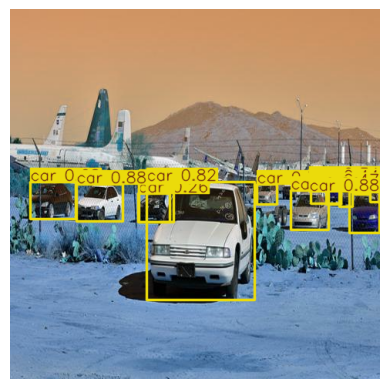


image 1/1 /kaggle/working/Vehicles-coco-2/test/images/000000416933_jpg.rf.8bc688be13de0b9a92dac9144b5180eb.jpg: 480x480 2 cars, 9.8ms
Speed: 1.4ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 480)


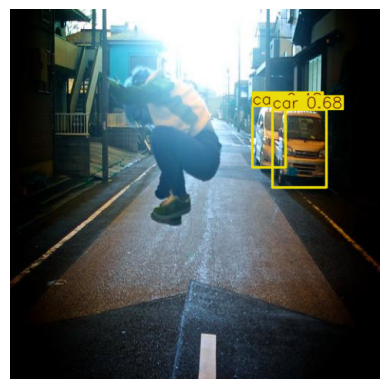

In [33]:
import random

model = YOLO('/kaggle/working/runs/detect/train3/weights/best.pt')

test_images_dir = '/kaggle/working/Vehicles-coco-2/test/images'

all_images = [img for img in os.listdir(test_images_dir) if img.endswith('.jpg')]

random_images = random.sample(all_images, 2)

for image_filename in random_images:
    image_path = os.path.join(test_images_dir, image_filename)
    
    result = model(image_path)
    
    img = result[0].plot()
    
    plt.imshow(img)
    plt.axis('off')
    plt.show()


## convert yolo model to onnx

In [34]:
model.export(format='onnx')


Ultralytics YOLOv8.2.92 🚀 Python-3.10.14 torch-2.4.0 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from '/kaggle/working/runs/detect/train3/weights/best.pt' with input shape (1, 3, 480, 480) BCHW and output shape(s) (1, 8, 4725) (5.9 MB)

ONNX: starting export with onnx 1.16.2 opset 19...
ONNX: export success ✅ 1.0s, saved as '/kaggle/working/runs/detect/train3/weights/best.onnx' (11.6 MB)

Export complete (2.6s)
Results saved to /kaggle/working/runs/detect/train3/weights
Predict:         yolo predict task=detect model=/kaggle/working/runs/detect/train3/weights/best.onnx imgsz=480  
Validate:        yolo val task=detect model=/kaggle/working/runs/detect/train3/weights/best.onnx imgsz=480 data=/kaggle/working/Vehicles-coco-2/data.yaml  
Visualize:       https://netron.app


'/kaggle/working/runs/detect/train3/weights/best.onnx'

Loading /kaggle/working/runs/detect/train3/weights/best.onnx for ONNX Runtime inference...

Found https://ultralytics.com/images/bus.jpg locally at bus.jpg


2024-09-12 17:56:12.230737062 [W:onnxruntime:, transformer_memcpy.cc:74 ApplyImpl] 4 Memcpy nodes are added to the graph main_graph for CUDAExecutionProvider. It might have negative impact on performance (including unable to run CUDA graph). Set session_options.log_severity_level=1 to see the detail logs before this message.


image 1/1 /kaggle/working/bus.jpg: 480x480 1 bus, 13.4ms
Speed: 5.1ms preprocess, 13.4ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 480)


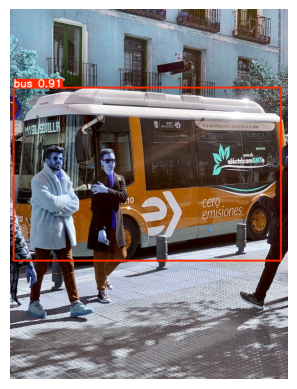

In [56]:

onnx_model = YOLO('/kaggle/working/runs/detect/train3/weights/best.onnx')
results = onnx_model.predict('https://ultralytics.com/images/bus.jpg', imgsz=480)
img = results[0].plot()

plt.imshow(img)
plt.axis('off')
plt.show()




image 1/1 /kaggle/working/Vehicles-coco-2/test/images/000000473531_jpg.rf.ada7b79310d7fe389dc37a2d2fb1bb9d.jpg: 480x480 1 car, 14.3ms
Speed: 1.3ms preprocess, 14.3ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 480)


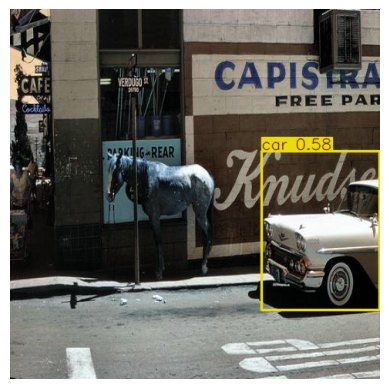


image 1/1 /kaggle/working/Vehicles-coco-2/test/images/000000272832_jpg.rf.b72ff2cc0ac48dbcb9bf3d833422bbcd.jpg: 480x480 1 bus, 10.8ms
Speed: 1.3ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 480)


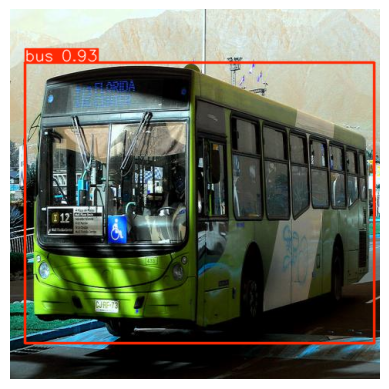

In [59]:
import random


test_images_dir = '/kaggle/working/Vehicles-coco-2/test/images'

all_images = [img for img in os.listdir(test_images_dir) if img.endswith('.jpg')]

random_images = random.sample(all_images, 2)

for image_filename in random_images:
    image_path = os.path.join(test_images_dir, image_filename)
    
    result = onnx_model.predict(image_path, imgsz=480)
    
    img = result[0].plot()
    
    plt.imshow(img)
    plt.axis('off')
    plt.show()
